## this homework will be split into 2. In the first part, due by Thursday 9th at noon, you will engineer features from time series. In the second half, due Wednesday 15th at midnight, you will use those features to find structure in the feature space (unsupervised learning, i.e. clustering) and classify by example with CART (supervised learning with random forest or gradient boosted tree models)

# Classifying astrophysical transients from photometry

## OVERVIEW

The PLAsTiCC challend is a Kaggle challange to classify astrophysical objects (e.g. stars, exploding stars, stars with planets transiting, black holes) based on their time variability in the light emission in 6 different bands. The sampling (the cadence of the observations) is designed to show what the upcming Rubin Observatory LSST (Legacy Survey of Space and Time) will see when it starts observing (in 2023). 

You can refer to this notebook https://www.kaggle.com/michaelapers/the-plasticc-astronomy-starter-kit (written by my good riend Gautham Narayan in fact!) to get started and ingest and preprocess the PLASTiCC challenge data. However, this is written with a class (object oriented) and we have not talked about this syntax in class. If you are not familiar with classes do not worry about it (but you should learn them!). Also I do want you to extract the features yourself. So use it as a guideline, but do not just copy and paste.

Your task is to extract features, i.e. representations of the time series, and run 2 models on these feautes: a cluster model, and a classification tree. 



In [39]:
import pandas as pd
import numpy as np
import pylab as pl
from scipy import stats 

from pandas.plotting import scatter_matrix
import glob
import json
import os
import statsmodels.api as sm
from google.colab import drive
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import statsmodels.tsa.api as tsa

from collections import OrderedDict
from sklearn.manifold import TSNE

%pylab inline


Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['test']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [0]:
pl.style.use("https://raw.githubusercontent.com/fedhere/MLTSA_FBianco/master/fbb.mplstyle")

In [3]:
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
cd gdrive/My\ Drive/

/content/gdrive/My Drive


In [5]:
!chmod 600 kaggle.json
envs = json.load(open("kaggle.json", "r"))
os.environ["KAGGLE_USERNAME"] = envs['username']
os.environ["KAGGLE_KEY"] = envs['key']
os.environ

environ({'ENV': '/root/.bashrc', 'GCS_READ_CACHE_BLOCK_SIZE_MB': '16', 'CLOUDSDK_CONFIG': '/content/.config', 'CUDA_VERSION': '10.1.243', 'PATH': '/usr/local/nvidia/bin:/usr/local/cuda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/tools/node/bin:/tools/google-cloud-sdk/bin:/opt/bin', 'HOME': '/root', 'LD_LIBRARY_PATH': '/usr/local/nvidia/lib:/usr/local/nvidia/lib64', 'LANG': 'en_US.UTF-8', 'SHELL': '/bin/bash', 'LIBRARY_PATH': '/usr/local/cuda/lib64/stubs', 'CUDA_PKG_VERSION': '10-1=10.1.243-1', 'SHLVL': '1', 'GCE_METADATA_TIMEOUT': '0', 'NCCL_VERSION': '2.4.8', 'NVIDIA_VISIBLE_DEVICES': 'all', 'TF_FORCE_GPU_ALLOW_GROWTH': 'true', 'DEBIAN_FRONTEND': 'noninteractive', 'CUDNN_VERSION': '7.6.5.32', 'LAST_FORCED_REBUILD': '20200316', 'JPY_PARENT_PID': '19', 'PYTHONPATH': '/env/python', 'DATALAB_SETTINGS_OVERRIDES': '{"kernelManagerProxyPort":6000,"kernelManagerProxyHost":"172.28.0.3","jupyterArgs":["--ip=\\"172.28.0.2\\""]}', 'NO_GCE_CHECK': 'True', 'GLIBCXX_FORCE_NEW':

# TASK:  Data Acquisition
 You can download the data from kaggle
 --- https://www.kaggle.com/c/PLAsTiCC-2018
 or from zenodo
 --- https://zenodo.org/record/2539456#.XonrIdNKjOQ
 Choose how to do it but make sure that it is a reproducible way (i.e. that Yuqic an grade each notebook and the data will be accessed automatically without modifications to the code). You will need the training data and the metadata files


In [6]:
cd MLTSA2020/

/content/gdrive/My Drive/MLTSA2020


In [0]:
mkdir hw5

In [8]:
cd hw5

/content/gdrive/My Drive/MLTSA2020/hw5


In [0]:
!kaggle competitions download -c PLAsTiCC-2018

In [10]:
ls

data_note.pdf.zip          test_set_batch3.csv.zip  test_set_batch9.csv.zip
sample_submission.csv.zip  test_set_batch4.csv.zip  test_set_metadata.csv.zip
test_set_batch10.csv.zip   test_set_batch5.csv.zip  test_set_sample.csv.zip
test_set_batch11.csv.zip   test_set_batch6.csv.zip  training_set.csv
test_set_batch1.csv.zip    test_set_batch7.csv.zip  training_set.csv.zip
test_set_batch2.csv.zip    test_set_batch8.csv.zip  training_set_metadata.csv


In [0]:
!unzip training_set.csv.zip

In [12]:
ls

data_note.pdf.zip          test_set_batch3.csv.zip  test_set_batch9.csv.zip
sample_submission.csv.zip  test_set_batch4.csv.zip  test_set_metadata.csv.zip
test_set_batch10.csv.zip   test_set_batch5.csv.zip  test_set_sample.csv.zip
test_set_batch11.csv.zip   test_set_batch6.csv.zip  training_set.csv
test_set_batch1.csv.zip    test_set_batch7.csv.zip  training_set.csv.zip
test_set_batch2.csv.zip    test_set_batch8.csv.zip  training_set_metadata.csv


In [13]:
lcvs = pd.read_csv('training_set.csv')

print("The dataset contains: (observations, columns)", lcvs.shape)

The dataset contains: (observations, columns) (1421705, 6)


In [0]:
lg_hold = lcvs[lcvs.object_id == 84716]

In [0]:
#lcvs = lcvs[:10000] #switch this out at the endS

In [16]:
lcvs.head()

,object_id,mjd,passband,flux,flux_err,detected
0,615,59750.4229,2,-544.810303,3.622952,1
1,615,59750.4306,1,-816.434326,5.553370,1
2,615,59750.4383,3,-471.385529,3.801213,1
3,615,59750.4450,4,-388.984985,11.395031,1
4,615,59752.4070,2,-681.858887,4.041204,1


read the Kaggle challenge for a description of the data . This "Starter Kit" which includes a notebook (written by y good friend Gautham Narayan) may be especially useful
https://www.kaggle.com/michaelapers/the-plasticc-astronomy-starter-kit

For each object there are 6 time series in 6 different passbands (see overview.) 

In [17]:
bands = lcvs["passband"].unique()
print("Passbands (filter) identifiers:", bands)

Passbands (filter) identifiers: [2 1 3 4 5 0]


In [18]:
objects = lcvs["object_id"].unique()
print("There are {} astrophysical simulated objects in my dataset".format(objects.shape[0]))

There are 7848 astrophysical simulated objects in my dataset


In [19]:
metadata = pd.read_csv("training_set_metadata.csv")
metadata.head()

,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target
0,615,349.046051,-61.943836,320.796530,-51.753706,1,0.0000,0.0000,0.0000,NaN,0.017,92
1,713,53.085938,-27.784405,223.525509,-54.460748,1,1.8181,1.6267,0.2552,45.4063,0.007,88
2,730,33.574219,-6.579593,170.455585,-61.548219,1,0.2320,0.2262,0.0157,40.2561,0.021,42
3,745,0.189873,-45.586655,328.254458,-68.969298,1,0.3037,0.2813,1.1523,40.7951,0.007,90
4,1124,352.711273,-63.823658,316.922299,-51.059403,1,0.1934,0.2415,0.0176,40.4166,0.024,90


In [20]:
metadata.columns

Index(['object_id', 'ra', 'decl', 'gal_l', 'gal_b', 'ddf', 'hostgal_specz',
       'hostgal_photoz', 'hostgal_photoz_err', 'distmod', 'mwebv', 'target'],
      dtype='object')

In [21]:
print("The metadata dataset contains more information for each time series: (time-series, columns)", metadata.shape)

The metadata dataset contains more information for each time series: (time-series, columns) (7848, 12)


# TASK : data visualization - plot some time series 
You always need to visualize your data to get a sense of what we are working with
that for each object I have 6 bands: each object is plotted separately, all bands for each object are plotted together.

**Include object 84716**


In [0]:
# preparing a normalization to pass to the color map to map red filters to red blue filters to blue
norm_band = Normalize(vmin=bands.min(), vmax=bands.max())

In [23]:
#pbnames = ['xkcd:sky blue','g','r','y','k','w']
pbnames = ["teal", 'blue', "orange", "black", "red", "grey"]
#pbnames = ["#red", "amber", "greyish", "faded green", "dusty purple", ]
test = lcvs[lcvs['object_id'] == 615]
test.columns

Index(['object_id', 'mjd', 'passband', 'flux', 'flux_err', 'detected'], dtype='object')

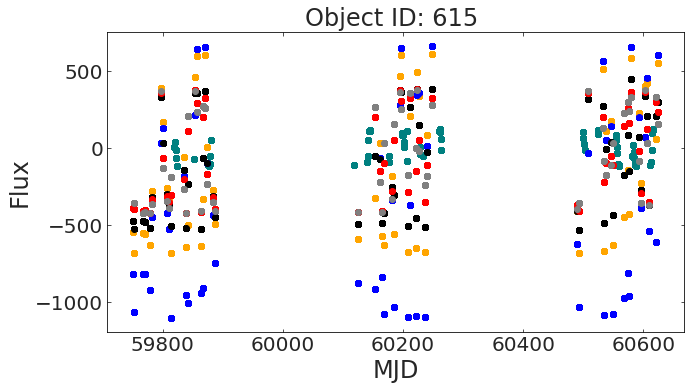

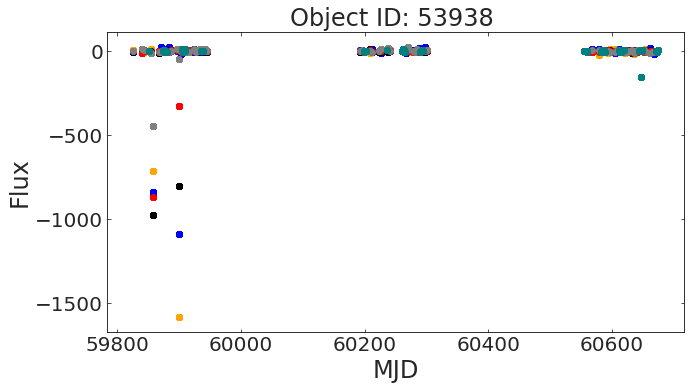

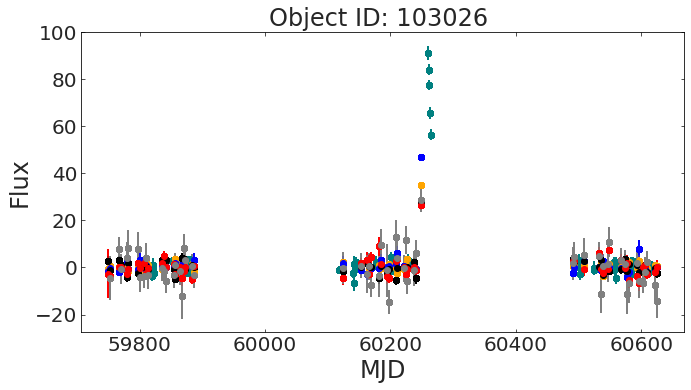

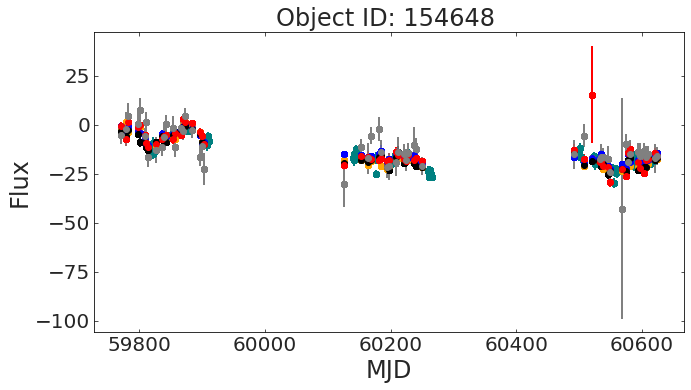

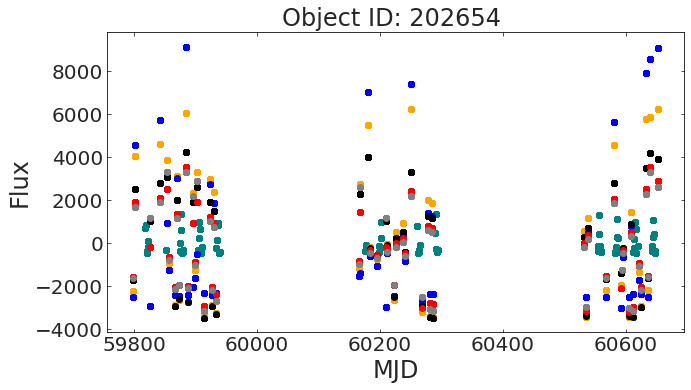

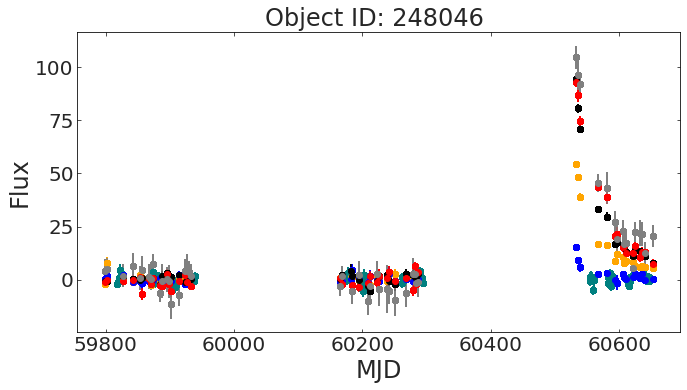

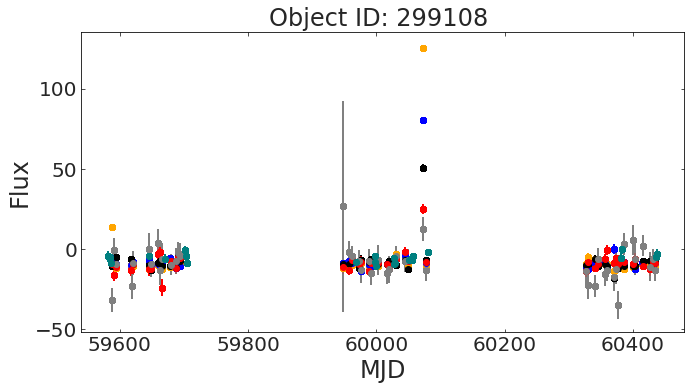

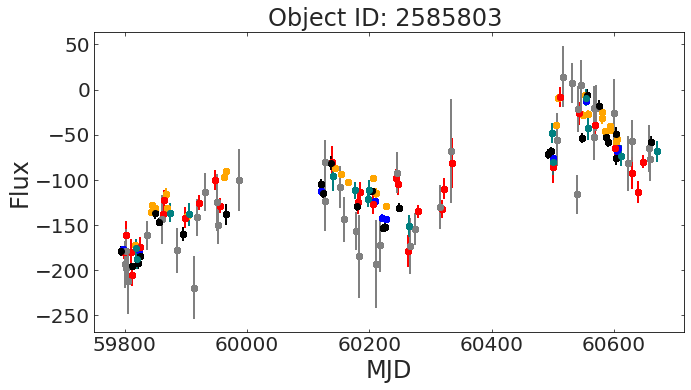

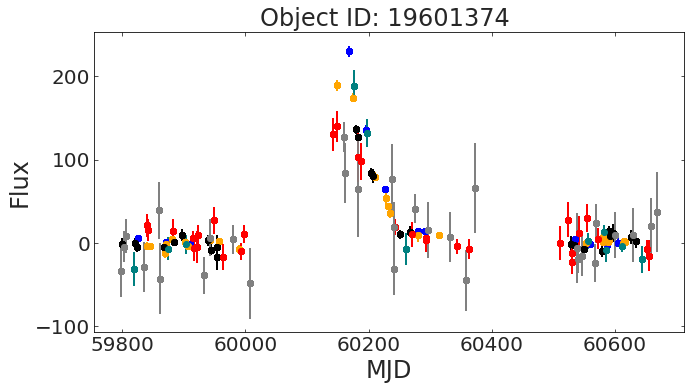

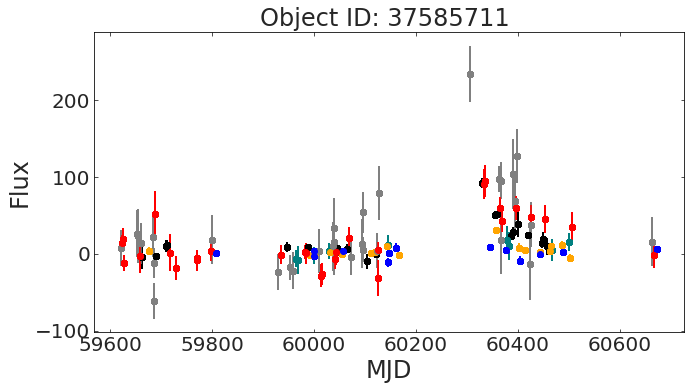

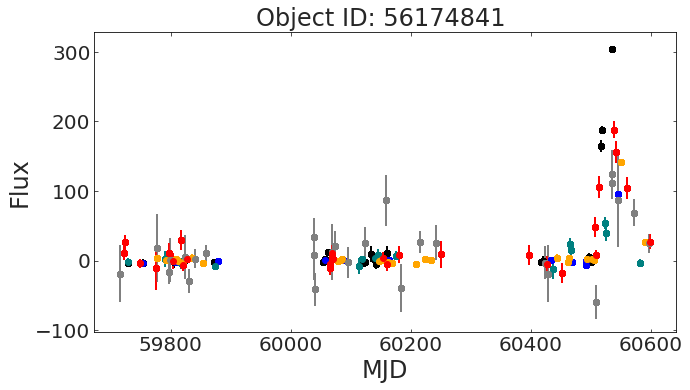

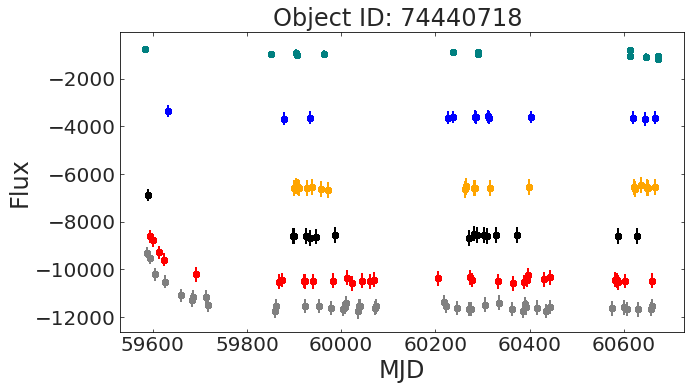

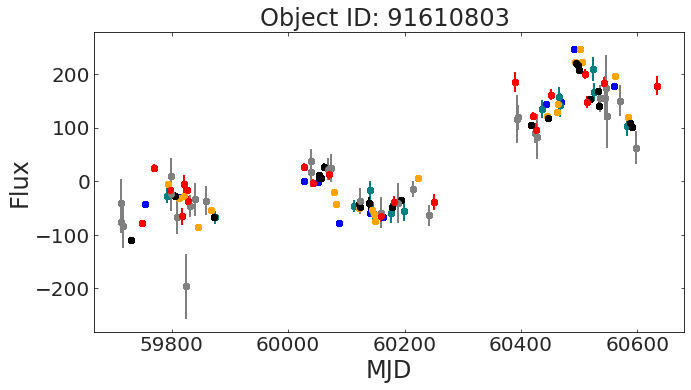

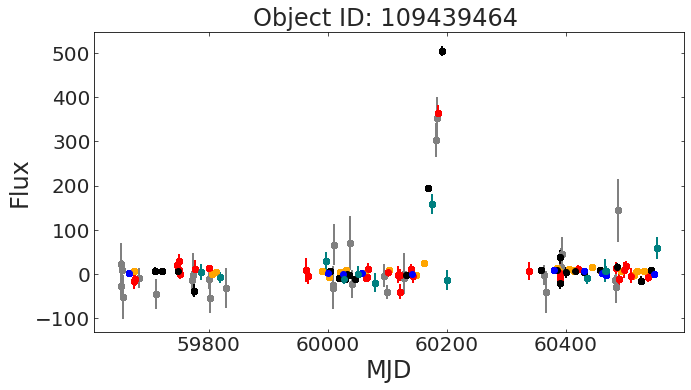

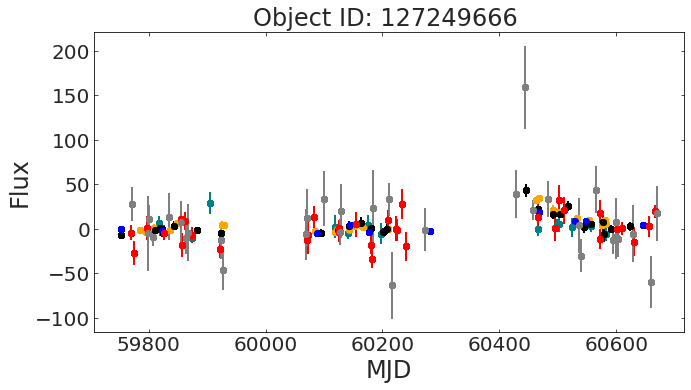

In [26]:
for i in range(0, len(lcvs),100000):
  name = lcvs['object_id'][i]
  obj = lcvs[lcvs['object_id'] == name]
  #name = obj.object_id.values[0]
  #fig, ax = plt.subplots(figsize=(8,6))
  for i, pb in enumerate(obj.passband):
              pbname = pbnames[pb]
              ind = obj['passband'] == pb
              # ax.errorbar( 
              #          test['flux'][ind],
              #          test['flux_err'][ind],
              #          fmt = 'o', color = pbname, label = f'{pbname}')
              pl.errorbar(obj['mjd'][ind],obj['flux'][ind], obj['flux_err'][ind], fmt = 'o', color = pbname)
  pl.xlabel('MJD', fontsize='large')
  pl.ylabel('Flux', fontsize='large')
  pl.title("Object ID: %s " % name)
  pl.tight_layout(rect=[0, 0, 1, 0.97])
  pl.show()

Figure 1: Plots of the Flux vs. Time for several data objecs in the light curve series. Different bands the object was observed in are displayed in different colors, with error bars. Note that the error for some objects is quite large, which may affect data later if not taken out. Furthermore there are distinctive features, like the right-side curve on obj. 4389. Objects in the last filter (marked grey) appear to account for most of the larger error bars. 

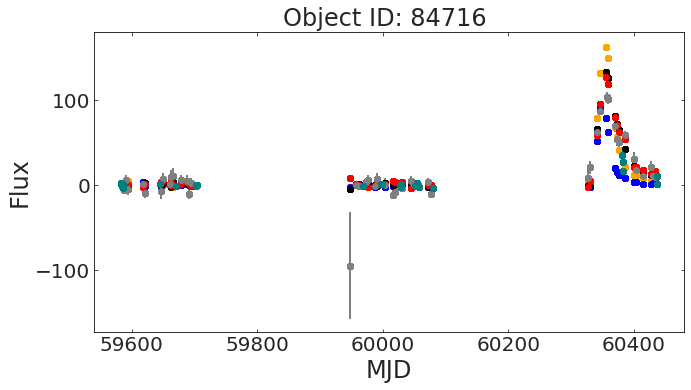

In [27]:
  name = lg_hold['object_id']
  obj = lg_hold
  name = obj.object_id.values[0]
  #fig, ax = plt.subplots(figsize=(8,6))
  for i, pb in enumerate(lg_hold.passband):
              pbname = pbnames[pb]
              ind = obj['passband'] == pb
              # ax.errorbar( 
              #          test['flux'][ind],
              #          test['flux_err'][ind],
              #          fmt = 'o', color = pbname, label = f'{pbname}')
              pl.errorbar(obj['mjd'][ind],obj['flux'][ind], obj['flux_err'][ind], fmt = 'o', color = pbname)
  pl.xlabel('MJD', fontsize='large')
  pl.ylabel('Flux', fontsize='large')
  pl.title("Object ID: %s " % name)
  pl.tight_layout(rect=[0, 0, 1, 0.97])
  pl.show()

Figure 2: same as figure 1, specifically displayig object 84716. likely chosen so that we see that large error in the middle. 

# TASK: Extract features
*You do not have to extract exaclyt the features I am extracting! These are just examples! Extract at least 6 features including 2 features from all three category below* 

The code that won the callenge did a number of smart things, of course. It was a feature based classification scheme, which included Gaussian Processes in the preprocessing. The feature extraction part of the code is here. https://github.com/kboone/avocado/blob/master/avocado/plasticc.py

We will work similarly, extracting some basic features for each lightcurve. 

Note: we are working with bigg-ish data! 
First off: every new piece should be developed on a subset of the dataset, then run on all the data only when ready. 
Still, if you try achieve goals by implementing for loops you are not going to be able to run the notebook for the whole data, or even only 1 batch of the full datase. A good solution is to use the groupby() method in pandas. I used groupby everywhere. Also it may be wise to write out intermediate outputs, so you do not have to loose work if your kernel dies or something similar. 

My plan is to extract:

- **from the original lightcurve**: 
    - mean, 
    - standard deviation, 
    - skewness, 
    - kurthosis, 
    - minimum 
    - maximmum,
    - error on the minimum and 
    - error on the maximum, 
- **from the standardized lightcurve**:
    - median 
    - slop of a line fit
    - intercept of a line fit
    - likelihood of the line fit
    - likelihood of a quadratic fit
    - sign of the quadratic parameter


- **from the metadata file**:
    - decl ; important because the position on the sky may determin if it is a galactic or extragalactic object
    - ddf_bool ; the kind of survey i.e. the data collection scheme that lead to the time series
    - hostgal_photoz
    - hostgal_photoz_err
    
The feature in the metadata files are the hardest ones to decide on because they require domain knowledge.
Most of the other features in the metadata are unknown for test objects (only known for the training set)

I am ok with you extracting different features! 

Extract **at least 6 features including 2 features from all three category above**: original lcv, standardized lcv, metadata. Justify each feature. Remember that if the features are extracted from the time series there will be 6 features for each choice of feature (for 6 passbands) so I end up with 94 features with the scheme outlined above

## TASK: 4.1
describe each feature you plan to extract. Briefly indicate why you think it is a valuable feature and what data type is it (e.g. continuous, binary, categorical, if continuous does it have a max or min value or is it unbound?)

        

## TASK 4.2 extract some features from the raw lightcurve - 
I have some examples of how I did it in the next few lines of code

In [0]:
means = lcvs.groupby(["object_id", "passband"])[["flux"]].mean()
stds = lcvs.groupby(["object_id", "passband"])[["flux"]].std()

In [0]:
#this code is so compact and pretty
features = means.rename({"flux": "mean"}, 
                        axis=1).merge(stds.rename({"flux": "std"}, 
                                axis=1), left_index=True, right_index=True)

In [31]:
features

mean           std
object_id passband                           
615       0           -3.254554     83.944735
          1         -385.699911    601.787302
          2         -134.146566    455.121346
          3         -121.103501    335.425053
          4          -55.954592    291.803449
...                         ...           ...
130779836 1          725.169852   1197.557111
          2         2690.360415   6440.422386
          3          755.993902   1443.868085
          4         3489.185336  11006.766106
          5         4151.358875   8687.101173

[47088 rows x 2 columns]

### higher order moments of the distribution can be obtained with the scipy.stats.moment() function which can be applied to a grouby() object
note that this way you can apply a function that takes only one argument, the argument over which groupby iterates (the flux here). But moments take 2: the value and the moment Create a unction call

In [0]:
def mom(x, numb):
    return stats.moment(x, moment = numb)

In [0]:
mom2 = pd.DataFrame(lcvs.groupby(["object_id", "passband"])["flux"].apply(mom, 2)) #variance
mom3 = pd.DataFrame(lcvs.groupby(["object_id", "passband"])["flux"].apply(mom, 3)) #skewness

In [0]:
features2 = mom2.rename({"flux": "variance"}, 
                        axis=1).merge(mom3.rename({"flux": "Skew"}, 
                                axis=1), left_index=True, right_index=True)

In [0]:
features = features.merge(features2.rename({"flux": "Skew"}, 
                                axis=1), left_index=True, right_index=True)

In [36]:
features

mean           std      variance          Skew
object_id passband                                                       
615       0           -3.254554     83.944735  6.934866e+03  7.266579e+04
          1         -385.699911    601.787302  3.559040e+05  8.593916e+07
          2         -134.146566    455.121346  2.035641e+05  3.040627e+07
          3         -121.103501    335.425053  1.105701e+05  1.049664e+07
          4          -55.954592    291.803449  8.368116e+04  4.717542e+06
...                         ...           ...           ...           ...
130779836 1          725.169852   1197.557111  1.314631e+06  2.360077e+09
          2         2690.360415   6440.422386  3.981988e+07  9.572595e+11
          3          755.993902   1443.868085  1.989993e+06  6.673022e+09
          4         3489.185336  11006.766106  1.164893e+08  5.307167e+12
          5         4151.358875   8687.101173  7.169244e+07  1.380872e+12

[47088 rows x 4 columns]


























### Even with the same standard deviation two distribution can be very different. 
Look at the this article for a great demonstation of that! https://heap.io/blog/data-stories/anscombes-quartet-and-why-summary-statistics-dont-tell-the-whole-story

I extracted  the max and min, but also their uncertainties becaus outlier points may be measurement issues, in which case the uncertainty may be large : see the plot you made for 84716!

If a distribution has spikes the standard deviation will be larger even if the other datapoints are exactly the same. Save the mean and the max of both original distribution and the standardized one (standardized = mean subtracted and divided by the standard deviation). 


In [0]:
class LightCurve(object):
    '''Light curve object for PLAsTiCC formatted data'''
    
    _passbands = OrderedDict([(0,'C4'),\
                              (1,'C2'),\
                              (2,'C3'),\
                              (3,'C1'),\
                              (4,'k'),\
                              (5,'C5')])
    
    _pbnames = ['u','g','r','i','z','y']
    def __init__(self, filename):
        '''Read in light curve data'''

        # self.DFlc     = pd.read_csv(filename)
        # self.filename = filename.replace('.csv','')
        self.DFlc = filename
        self._finalize()

    def _finalize(self):
        '''Store individual passband fluxes as object attributes'''
        # in this example, we'll use the weighted mean to normalize the features
        weighted_mean = lambda flux, dflux: np.sum(flux*(flux/dflux)**2)/np.sum((flux/dflux)**2)
        
        # define some functions to compute simple descriptive statistics
        normalized_flux_std = lambda flux, wMeanFlux: np.std(flux/wMeanFlux, ddof = 1)
        normalized_amplitude = lambda flux, wMeanFlux: (np.max(flux) - np.min(flux))/wMeanFlux
        normalized_MAD = lambda flux, wMeanFlux: np.median(np.abs((flux - np.median(flux))/wMeanFlux))
        beyond_1std = lambda flux, wMeanFlux: sum(np.abs(flux - wMeanFlux) > np.std(flux, ddof = 1))/len(flux)
        
        for pb in self._passbands:
            ind = self.DFlc['passband'] == pb
            pbname = self._pbnames[pb]
            
            if len(self.DFlc[ind]) == 0:
                setattr(self, f'{pbname}Std', np.nan)
                setattr(self, f'{pbname}Amp', np.nan)
                setattr(self, f'{pbname}MAD', np.nan)
                setattr(self, f'{pbname}Beyond', np.nan)
                setattr(self, f'{pbname}Skew', np.nan)
                continue
            
            f  = self.DFlc['flux'][ind]
            df = self.DFlc['flux_err'][ind]
            m  = weighted_mean(f, df)
            
            # we'll save the measurements in each passband to simplify access.
            setattr(self, f'{pbname}Flux', f)
            setattr(self, f'{pbname}FluxUnc', df)
            setattr(self, f'{pbname}Mean', m)
            
            # compute the features
            std = normalized_flux_std(f, df)
            amp = normalized_amplitude(f, m)
            mad = normalized_MAD(f, m)
            beyond = beyond_1std(f, m)
            skew = stats.skew(f) 
            
            # and save the features
            setattr(self, f'{pbname}Std', std)
            setattr(self, f'{pbname}Amp', amp)
            setattr(self, f'{pbname}MAD', mad)
            setattr(self, f'{pbname}Beyond', beyond)
            setattr(self, f'{pbname}Skew', skew)

In [0]:
#Using code from resource to find relevant features (like normalized mean, std, etc). for each passband for each object. For first 1000 objects
light_curves = []
#for i in range(len(lcvs)):
for i in range(1000):
  name = lcvs['object_id'][i]
  obj = lcvs[lcvs['object_id'] == name]
  lg = LightCurve(obj)
  light_curves.append(lg)

In [0]:
# i = 0
# name = lcvs['object_id'][i]
# obj = lcvs[lcvs['object_id'] == name]
# lg = LightCurve(obj)

In [0]:
#lc = LightCurve('training_set.csv')

In [0]:
maxs = lcvs.groupby(["object_id", "passband"])[["flux", "flux_err"]].max()
mins = lcvs.groupby(["object_id", "passband"])[["flux", "flux_err"]].min()

In [46]:
features4 = maxs.rename({"flux": "max", "flux_err" : "max_unc"}, 
                        axis=1).merge(mins.rename({"flux": "min", "flux_err" : "min_unc"},
                        axis = 1), left_index=True, right_index=True)
features = features.merge(features4, left_index=True, right_index=True)
features

mean           std  ...          min    min_unc
object_id passband                             ...                        
615       0           -3.254554     83.944735  ...  -116.913223   2.844200
          1         -385.699911    601.787302  ... -1100.440063   3.034533
          2         -134.146566    455.121346  ...  -681.858887   2.130510
          3         -121.103501    335.425053  ...  -530.644592   2.499724
          4          -55.954592    291.803449  ...  -422.184509   2.899512
...                         ...           ...  ...          ...        ...
130779836 1          725.169852   1197.557111  ...   -34.273514  18.947685
          2         2690.360415   6440.422386  ...   -14.478923  13.604170
          3          755.993902   1443.868085  ...   -41.850040  15.891281
          4         3489.185336  11006.766106  ...   -72.634567  14.743795
          5         4151.358875   8687.101173  ...   -86.457382  29.652933

[47088 rows x 8 columns]

In [0]:
# features4 = maxs.rename({"flux": "max", "flux_err" : "max_unc"}, 
#                         axis=1)
# features5 = mins.rename({"flux": "min", "flux_err" : "min_unc"},
#                         axis = 1)


## TASK 4.3 Standardize the lcvs and extract some features from the raw lightcurve - 
I have some examples of how I did it in the next few lines of code

In [0]:
lcvs["fluxnormed"] = 0.

In [0]:
# normalize each LC this is very slow. can you make  it faster?
def normed(df):
   mean = np.mean(df.flux)
   std = np.std(df.flux)
   df.fluxnormed = (df.flux - mean) / std
   return df
   #return df
    
    
lcvs = lcvs.groupby(["object_id", "passband"]).apply(normed)

#normed the whole dang thing

# this is how it could be done in a for loop. But it would take hours!!
#for obj in  objects:
#    for band in bands:
#        lcvs[lcvs.object_id == obj][lcvs.passband == band].normedflux =\
#             lcvs[lcvs.object_id == obj][lcvs.passband == band].flux - means.loc[obj, band]
#        lcvs[lcvs.object_id == obj][lcvs.passband == band].normedflux /= stds.loc[obj, band]        


In [49]:
np.mean(lcvs['fluxnormed'])
np.std(lcvs['fluxnormed'])

0.9999999999999769

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
findfont: Font family ['["sans-serif"]'] not found. Falling back to DejaVu Sans.
findfont: Font family ['["sans-serif"]'] not found. Falling back to DejaVu Sans.


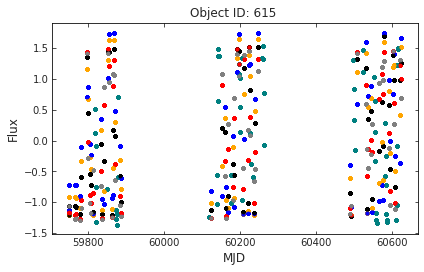

In [50]:
#for i in range(0, len(lcvs),700):
for i in range(0,1):
  name = lcvs['object_id'][i]
  obj = lcvs[lcvs['object_id'] == name]
  obj['fluxnormed'] = lcvs['fluxnormed'][lcvs['object_id'] == name]
  #name = obj.object_id.values[0]
  #fig, ax = plt.subplots(figsize=(8,6))
  for i, pb in enumerate(obj.passband):
              pbname = pbnames[pb]
              ind = obj['passband'] == pb
              # ax.errorbar( 
              #          test['flux'][ind],
              #          test['flux_err'][ind],
              #          fmt = 'o', color = pbname, label = f'{pbname}')
              #pl.errorbar(obj['mjd'][ind],obj['flux'][ind], obj['flux_err'][ind], fmt = 'o', color = pbname)
              pl.scatter(obj['mjd'][ind], obj['fluxnormed'][ind], color = pbname, s = 8)
  pl.xlabel('MJD', fontsize='large')
  pl.ylabel('Flux', fontsize='large')
  pl.title("Object ID: %s " % name)
  pl.tight_layout(rect=[0, 0, 1, 0.97])
  pl.show()

Figure 3: Test plot of the first light curve to verify that the flux is now normalized, stored in lcvs['fluxnormed']. Data now has a mean of 0, standard deviation of 1. 

### min and max: if I did not get the means before I would store these data. seance I have the mean and the min max of the not standardized data this is irrelevant


In [0]:
maxs_standardized = pd.DataFrame(lcvs.groupby(["object_id", "passband"])["fluxnormed"].max())
mins_standardized = pd.DataFrame(lcvs.groupby(["object_id", "passband"])["fluxnormed"].min())

In [52]:
maxs_standardized

fluxnormed
object_id passband            
615       0           1.542312
          1           1.753883
          2           1.653730
          3           1.704677
          4           1.513803
...                        ...
130779836 1           2.263933
          2           4.555525
          3           3.005059
          4           4.771017
          5           2.941590

[47088 rows x 1 columns]

### the median of the standardizeed distribution will convey the location of the "center of mass" of the data with respect to the mean


In [0]:
medians = lcvs.groupby(["object_id", "passband"])[["fluxnormed"]].median()

In [54]:
features5 = maxs_standardized.rename({"fluxnormed": "max_normed"}, 
                        axis=1).merge(mins_standardized.rename({"fluxnormed": "min_normed"},
                        axis = 1), left_index=True, right_index=True)
features = features.merge(features5, left_index=True, right_index=True)
features

mean           std  ...  max_normed  min_normed
object_id passband                             ...                        
615       0           -3.254554     83.944735  ...    1.542312   -1.364846
          1         -385.699911    601.787302  ...    1.753883   -1.198069
          2         -134.146566    455.121346  ...    1.653730   -1.213953
          3         -121.103501    335.425053  ...    1.704677   -1.231625
          4          -55.954592    291.803449  ...    1.513803   -1.266018
...                         ...           ...  ...         ...         ...
130779836 1          725.169852   1197.557111  ...    2.263933   -0.662359
          2         2690.360415   6440.422386  ...    4.555525   -0.428639
          3          755.993902   1443.868085  ...    3.005059   -0.565578
          4         3489.185336  11006.766106  ...    4.771017   -0.330011
          5         4151.358875   8687.101173  ...    2.941590   -0.500502

[47088 rows x 10 columns]

## TASK 4.4: parametric features: extract some features that come from simple models of the lightcurve



### fit a line to the standardized data and store the slope and intercept as new features. See here for how to apply this with a groupby https://stackoverflow.com/questions/14529838/apply-multiple-functions-to-multiple-groupby-columns
If you can use groupby you get an extra point (cause that would be a very efficient way to do it)

In [0]:
def linfit(x):
    pars = np.polyfit(range(len(x)), x["fluxnormed"].values, 1)
    return pars
linfits = lcvs.groupby(["object_id", "passband"]).apply(linfit)

In [56]:
linfits.shape

(47088,)

In [57]:
linfits.values

array([array([ 0.00572131, -0.17736055]),
       array([ 0.01415419, -0.40339438]),
       array([ 0.01783017, -0.50815996]), ...,
       array([-0.09442251,  0.99143638]),
       array([-0.03964509,  0.49556369]),
       array([-0.06616158,  0.62853498])], dtype=object)

In [0]:
slopes = [x[0] for x in linfits.values[:]]
intercepts = [x[1] for x in linfits.values[:]]


In [0]:
features["slopes"] = slopes
features["intercepts"] = intercepts

In [60]:
features

mean           std  ...    slopes  intercepts
object_id passband                             ...                      
615       0           -3.254554     83.944735  ...  0.005721   -0.177361
          1         -385.699911    601.787302  ...  0.014154   -0.403394
          2         -134.146566    455.121346  ...  0.017830   -0.508160
          3         -121.103501    335.425053  ...  0.020653   -0.588620
          4          -55.954592    291.803449  ...  0.022539   -0.642347
...                         ...           ...  ...       ...         ...
130779836 1          725.169852   1197.557111  ... -0.197775    1.087761
          2         2690.360415   6440.422386  ... -0.061238    0.734858
          3          755.993902   1443.868085  ... -0.094423    0.991436
          4         3489.185336  11006.766106  ... -0.039645    0.495564
          5         4151.358875   8687.101173  ... -0.066162    0.628535

[47088 rows x 12 columns]

### A quadratic function can tell you if the time series is concave or convex. 
### If we fit both line and a quadratic we can also us the likelihood ratio to see wchich fit is best (remember the first couple of classes)

In [61]:
# this is slow!!
# from statsmodels.formula.api import ols
# def quadfit(x):
#     x['t'] = x.mjd - x.iloc[0].mjd
#     m1 = ols(formula='fluxnormed~t + 1', data=x).fit()
#     m2 = ols(formula='fluxnormed~pow(t, 2) + t + 1', data=x).fit()
    
#     pars = m2.llf, m1.llf, np.sign(m2.params[1])
#     return pars
# ols = lcvs.groupby(["object_id", "passband"]).apply(quadfit)

KeyboardInterrupt: ignored

In [0]:
#SAVE FOR LATER

# ll1 = ... #L1 is absolute error. Np.sum(y-)
# ll2 = ...
# ll3 = ...
# features["ll1"] = ...
# features["ll2"] = ...
# features["ll3"] = ...

## Task 5: show your engineered feature space and add features from the metadata file

Note that in the way I cereated the feature dataframe I have a feature column for each object and bandpass. I need to manipulate the dataframe so that I have 6xN features per object where N is the number of eatures I engineered. 

In [90]:
features.head()

mean         std  ...    slopes  intercepts
object_id passband                          ...                      
615       0          -3.254554   83.944735  ...  0.005721   -0.177361
          1        -385.699911  601.787302  ...  0.014154   -0.403394
          2        -134.146566  455.121346  ...  0.017830   -0.508160
          3        -121.103501  335.425053  ...  0.020653   -0.588620
          4         -55.954592  291.803449  ...  0.022539   -0.642347

[5 rows x 12 columns]

In [0]:
# unstack will do the trick ... 
allfeatures = features.reset_index().set_index(['object_id','passband']).stack(
    ).unstack([1,2])


In [92]:
allfeatures.head()

passband          0                          ...          5                     
               mean        std     variance  ... min_normed    slopes intercepts
object_id                                    ...                                
615       -3.254554  83.944735  6934.865833  ...  -1.284695  0.021508  -0.602238
713       -2.720398   7.113509    49.879128  ...  -1.766173 -0.038246   1.051776
730       -0.048080   1.828872     3.298318  ...  -1.795204  0.019807  -0.495178
745        1.797523   4.374445    18.869993  ...  -0.813083 -0.002842   0.076744
1124       0.660948   2.360084     5.481586  ...  -0.835803  0.015693  -0.439406

[5 rows x 72 columns]

In [93]:
np.shape(allfeatures)

(7848, 72)

In [65]:
metadata.head()

,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target
0,615,349.046051,-61.943836,320.796530,-51.753706,1,0.0000,0.0000,0.0000,NaN,0.017,92
1,713,53.085938,-27.784405,223.525509,-54.460748,1,1.8181,1.6267,0.2552,45.4063,0.007,88
2,730,33.574219,-6.579593,170.455585,-61.548219,1,0.2320,0.2262,0.0157,40.2561,0.021,42
3,745,0.189873,-45.586655,328.254458,-68.969298,1,0.3037,0.2813,1.1523,40.7951,0.007,90
4,1124,352.711273,-63.823658,316.922299,-51.059403,1,0.1934,0.2415,0.0176,40.4166,0.024,90


In [0]:
allfeatures = allfeatures.merge(metadata, on = 'object_id')
#I think its this line

In [100]:
allfeatures.head()

,object_id,"(0, mean)","(0, std)","(0, variance)","(0, Skew)","(0, max)","(0, max_unc)","(0, min)","(0, min_unc)","(0, max_normed)","(0, min_normed)","(0, slopes)","(0, intercepts)","(1, mean)","(1, std)","(1, variance)","(1, Skew)","(1, max)","(1, max_unc)","(1, min)","(1, min_unc)","(1, max_normed)","(1, min_normed)","(1, slopes)","(1, intercepts)","(2, mean)","(2, std)","(2, variance)","(2, Skew)","(2, max)","(2, max_unc)","(2, min)","(2, min_unc)","(2, max_normed)","(2, min_normed)","(2, slopes)","(2, intercepts)","(3, mean)","(3, std)","(3, variance)",...,"(4, min)","(4, min_unc)","(4, max_normed)","(4, min_normed)","(4, slopes)","(4, intercepts)","(5, mean)","(5, std)","(5, variance)","(5, Skew)","(5, max)","(5, max_unc)","(5, min)","(5, min_unc)","(5, max_normed)","(5, min_normed)","(5, slopes)","(5, intercepts)",ra_x,decl_x,gal_l_x,gal_b_x,ddf_x,hostgal_specz_x,hostgal_photoz_x,hostgal_photoz_err_x,distmod_x,mwebv_x,target_x,ra_y,decl_y,gal_l_y,gal_b_y,ddf_y,hostgal_specz_y,hostgal_photoz_y,hostgal_photoz_err_y,distmod_y,mwebv_y,target_y
0,615,-3.254554,83.944735,6934.865833,72665.792850,125.182808,4.737393,-116.913223,2.844200,1.542312,-1.364846,0.005721,-0.177361,-385.699911,601.787302,355904.026224,8.593916e+07,660.626343,6.952323,-1100.440063,3.034533,1.753883,-1.198069,0.014154,-0.403394,-134.146566,455.121346,203564.138816,3.040627e+07,611.984558,4.333287,-681.858887,2.130510,1.653730,-1.213953,0.017830,-0.508160,-121.103501,335.425053,110570.138947,...,-422.184509,2.899512,1.513803,-1.266018,0.022539,-0.642347,-47.449847,294.779522,85370.493377,3.041829e+06,378.188141,12.845472,-422.815094,6.073453,1.456755,-1.284695,0.021508,-0.602238,349.046051,-61.943836,320.796530,-51.753706,1,0.0000,0.0000,0.0000,NaN,0.017,92,349.046051,-61.943836,320.796530,-51.753706,1,0.0000,0.0000,0.0000,NaN,0.017,92
1,713,-2.720398,7.113509,49.879128,89.634243,14.509829,3.348282,-14.735178,1.470152,2.439673,-1.701204,-0.041732,1.439744,-1.019804,5.712334,32.048070,-1.551087e+01,9.129021,3.545214,-11.715749,0.707228,1.792730,-1.889375,-0.052115,1.433174,-0.794238,5.770738,32.706748,-4.127475e+00,10.529041,2.530638,-10.067919,0.639458,1.979947,-1.621562,-0.054375,1.495303,-0.986966,6.450413,40.864832,...,-12.286801,1.429430,1.689606,-1.793290,-0.050921,1.400324,-1.794175,7.094073,49.427194,7.377121e+01,14.770886,9.115748,-14.211164,3.523145,2.356189,-1.766173,-0.038246,1.051776,53.085938,-27.784405,223.525509,-54.460748,1,1.8181,1.6267,0.2552,45.4063,0.007,88,53.085938,-27.784405,223.525509,-54.460748,1,1.8181,1.6267,0.2552,45.4063,0.007,88
2,730,-0.048080,1.828872,3.298318,2.093148,5.942166,3.110694,-3.459960,1.132809,3.298363,-1.878657,-0.001811,0.064288,0.141057,1.807229,3.203266,2.623669e+00,5.693109,3.564052,-3.393080,0.698751,3.102109,-1.974635,0.003198,-0.081558,2.400870,5.559483,30.313471,3.864890e+02,20.994711,2.483539,-2.848838,0.695106,3.377157,-0.953493,0.027168,-0.692777,3.236164,8.191987,65.818099,...,-5.836310,1.614300,3.474953,-0.956644,0.022777,-0.569422,4.539396,13.332758,174.276892,3.751336e+03,47.310059,11.281384,-19.159811,4.175368,3.239859,-1.795204,0.019807,-0.495178,33.574219,-6.579593,170.455585,-61.548219,1,0.2320,0.2262,0.0157,40.2561,0.021,42,33.574219,-6.579593,170.455585,-61.548219,1,0.2320,0.2262,0.0157,40.2561,0.021,42
3,745,1.797523,4.374445,18.869993,162.368381,18.014029,3.093587,-3.874349,0.957792,3.733115,-1.305691,-0.013181,0.467936,5.717394,25.964659,662.124902,1.161627e+05,192.244293,3.585434,-3.618410,0.567170,7.248890,-0.362812,-0.003860,0.106157,9.711532,31.957997,1003.075853,1.758302e+05,220.795212,2.334581,-2.159753,0.604430,6.664810,-0.374827,-0.003913,0.107606,14.412924,34.967698,1200.905234,...,-15.494463,1.588148,5.202498,-0.873566,-0.004818,0.132484,10.746138,26.060130,666.782529,5.309464e+04,141.513290,55.892746,-10.249387,3.737703,5.064150,-0.813083,-0.002842,0.076744,0.189873,-45.586655,328.254458,-68.969298,1,0.3037,0.2813,1.1523,40.7951,0.007,90,0.189873,-45.586655,328.254458,-68.9692

* Deliverable: what is the shape of your final feature space?

In [101]:
print("My feature space is {} features (columns)".format(len(allfeatures.columns)))

My feature space is 95 features (columns)


## Task 6: Create your train and test set out of the feature matrix and preprocess them to remove correlation by scaling them along the feature axis
The goall is to have a fewature matrix, the endogenous variables, X, and the target vector, the y exogenous variable for each training and test set.
Scale your training and test sets to remove the correlation: each feature is preprocessed so that it is mean=0 and standard deviation =1 - we will talk about it in class but make sure you deliver in this notebook the scaled features as below.

### make sure you deal with missing data

In [102]:
# check for NaNs and infinities
print("there are {} NaN and {} infinity entries".format(
 (allfeatures.isna().sum().sum()), np.prod(allfeatures.shape) - (np.isfinite(allfeatures).sum().sum())))


there are 4650 NaN and 4650 infinity entries


In [103]:
np.isfinite(allfeatures).sum()

object_id               7848
(0, mean)               7848
(0, std)                7848
(0, variance)           7848
(0, Skew)               7848
                        ... 
hostgal_photoz_y        7848
hostgal_photoz_err_y    7848
distmod_y               5523
mwebv_y                 7848
target_y                7848
Length: 95, dtype: int64

I the problem is with one of the likelihoods. 
I can drop that feature from the dataset or replace with something else. 



In [104]:
## dropping the observation
allfeatures.shape, allfeatures.replace([np.inf, -np.inf], np.nan).dropna().shape

#THIS IS WHERE ERROR IS

((7848, 95), (5523, 95))

In [105]:
## dropping the feature
allfeatures.shape, allfeatures.replace([np.inf, -np.inf], np.nan).dropna(axis=1).shape


((7848, 95), (7848, 93))

In [106]:
## filling with something else
allfeatures.shape, allfeatures.replace([np.inf, -np.inf], np.nan).fillna(-99).shape


((7848, 95), (7848, 95))

In [0]:
# -- personally I choose to drop the feature 
allfeatures = allfeatures.replace([np.inf, -np.inf], np.nan).dropna(axis=1)


## split train-test set

In [0]:
X = allfeatures.iloc[:,:-1]
y = allfeatures.iloc[:,-1]

import sklearn
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
     X, y, test_size=0.33, random_state=25)
#remember to use the random state so that your work is reproducible and use a split between 60-40 and 75-25. 



## scale train and test set

In [109]:

from sklearn import preprocessing
Xtrain_scaled = preprocessing.scale(X_train)
Xtest_scaled = preprocessing.scale(X_test)

print("scaled training data feature mean and standard deviations: ", 
      Xtrain_scaled.mean(axis=0), Xtrain_scaled.std(axis=0))



scaled training data feature mean and standard deviations:  [-2.70271105e-18 -2.70271105e-18  5.40542211e-18 -4.72974434e-18
 -9.45948868e-18 -6.08109987e-18 -6.75677763e-18 -2.70271105e-18
 -9.45948868e-18 -1.01351664e-17 -1.35135553e-18 -5.40542211e-18
  8.10813316e-18  2.02703329e-18 -9.45948868e-18 -2.70271105e-18
 -6.75677763e-18  6.75677763e-18 -2.70271105e-18 -1.35135553e-17
 -5.40542211e-18 -1.89189774e-17 -5.40542211e-18  4.05406658e-18
 -2.02703329e-17 -2.02703329e-18  6.75677763e-18 -5.40542211e-18
  0.00000000e+00 -4.05406658e-18 -5.40542211e-18 -5.40542211e-18
  1.35135553e-18 -2.43243995e-17  1.01351664e-17  1.62162663e-17
  1.35135553e-18  3.04054993e-18 -1.08108442e-17  6.75677763e-19
  8.10813316e-18 -2.70271105e-18 -5.40542211e-18  8.10813316e-18
  0.00000000e+00 -5.40542211e-18  1.62162663e-17  1.08108442e-17
  3.37838882e-18 -3.37838882e-18 -5.40542211e-18  5.40542211e-18
 -2.70271105e-18 -6.75677763e-18 -1.01351664e-17 -2.70271105e-18
 -4.05406658e-18 -8.78381092e-

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:173: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:173: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "



# Task 7: We will talk about what the next task means in class. read on to see how one can visualize a large dimensional feature space to plan the analysis and produce a 2D t-SNE projection of your feature space and visualize it. 
If you are lucky, this will be a pretty plot!
a great model to **Visualize** structure in data is  t-SNE: t-distributed Stocastic Neighbourhood Embedding
It project N-dimensional data on a 2-dimensional surface preserving the N-dimensional distance. If thre is structure in the feature space, it should show. If there is structure in feature space, clustering is a promising technique.


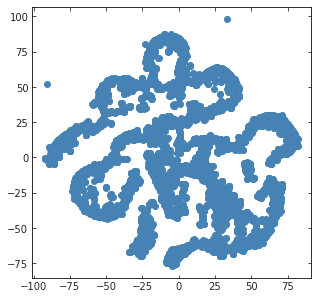

Figure: the 2D projection of the 79-dimensional feature space we created by extracting features from the time series. The separation of the objects in the t-distribution based stocastic neighbourhood embedding (t-SNE) is promising: t-SNE is an embedding (a transformation to a different coordinate space) which is designed to preserve Eucledianpairwise distances existing in the higher dimensional parameter space. How many clusters can you see in this embedding?A note: since the t_SNE produces a projection of the feature space on an ideal set of coordinates, this is the only cxase in which you are allowed not to label your axes!


In [111]:
X_embedded = TSNE(n_components=2, random_state=25).fit_transform(X)
X_embedded.shape
pl.figure(figsize=(5,5))
pl.scatter(X_embedded[:,0], X_embedded[:,1])
pl.show()
print("Figure: the 2D projection of the 79-dimensional feature space we created by extracting features from the time series. " + 
      "The separation of the objects in the t-distribution based stocastic neighbourhood embedding (t-SNE) is promising: " + 
      "t-SNE is an embedding (a transformation to a different coordinate space) which is designed to preserve Eucledian" + 
      "pairwise distances existing in the higher dimensional parameter space. " + 
      "How many clusters can you see in this embedding?" + 
      "A note: since the t_SNE produces a projection of the feature space on an ideal set of coordinates, " + 
      "this is the only cxase in which you are allowed not to label your axes!")

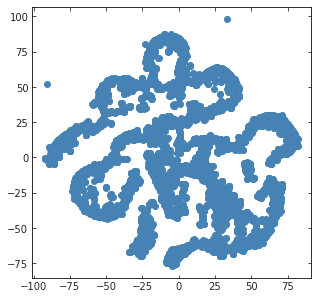

Figure: the 2D projection of the 79-dimensional feature space we created by extracting features from the time series. The separation of the objects in the t-distribution based stocastic neighbourhood embedding (t-SNE) is promising: t-SNE is an embedding (a transformation to a different coordinate space) which is designed to preserve Eucledianpairwise distances existing in the higher dimensional parameter space. How many clusters can you see in this embedding?A note: since the t_SNE produces a projection of the feature space on an ideal set of coordinates, this is the only cxase in which you are allowed not to label your axes!


In [112]:
X_embedded = TSNE(n_components=2, random_state=25).fit_transform(X)
X_embedded.shape
pl.figure(figsize=(5,5))
pl.scatter(X_embedded[:,0], X_embedded[:,1])
pl.show()
print("Figure: the 2D projection of the 79-dimensional feature space we created by extracting features from the time series. " + 
      "The separation of the objects in the t-distribution based stocastic neighbourhood embedding (t-SNE) is promising: " + 
      "t-SNE is an embedding (a transformation to a different coordinate space) which is designed to preserve Eucledian" + 
      "pairwise distances existing in the higher dimensional parameter space. " + 
      "How many clusters can you see in this embedding?" + 
      "A note: since the t_SNE produces a projection of the feature space on an ideal set of coordinates, " + 
      "this is the only cxase in which you are allowed not to label your axes!")

We have to assure that the clusters map to the target variable tho. So I will redo the plot colorcoded by target variable

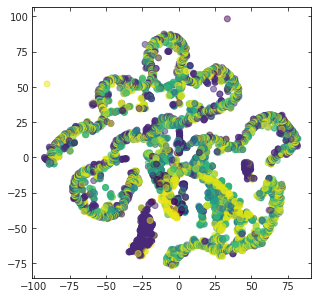

In [113]:
norm_obj= Normalize(vmin=y.min(), vmax=y.max())
len([c for c in pl.cm.RdBu_r(norm_obj(y.values))]), X_embedded.shape
pl.figure(figsize=(5,5))
pl.scatter(X_embedded[:,0], X_embedded[:,1],  
           color=[c for c in pl.cm.viridis(norm_obj(y.values))], alpha=0.5);

Figure: the purity of the sample is not good in the t-SNE projection against the target variable.

Does this map better on other features in the metadata?

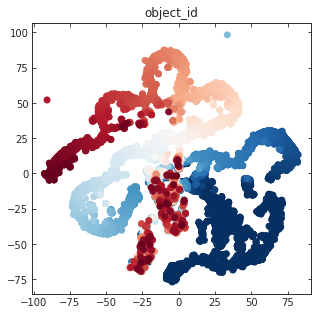

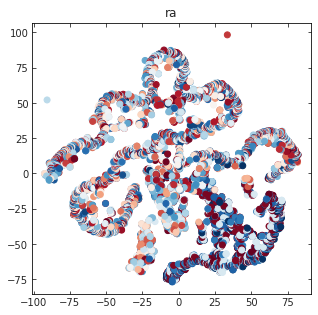

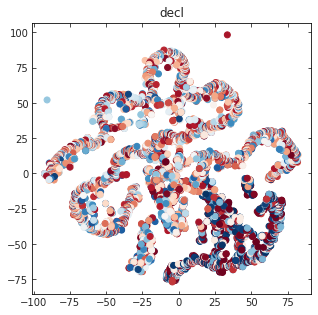

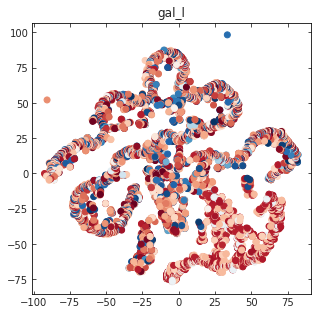

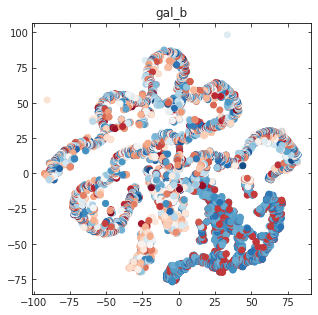

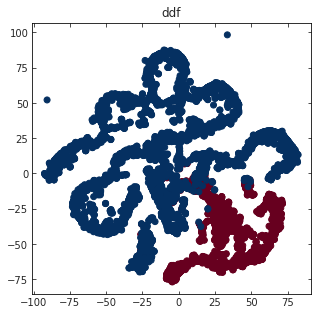

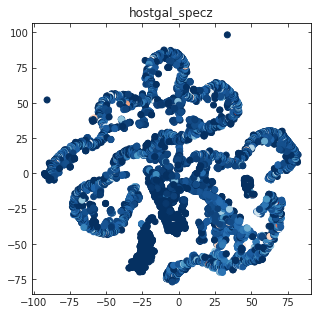

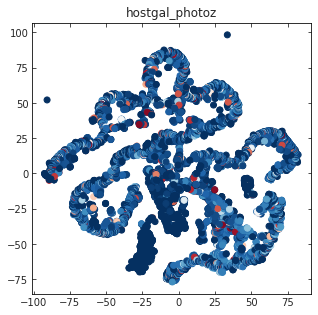

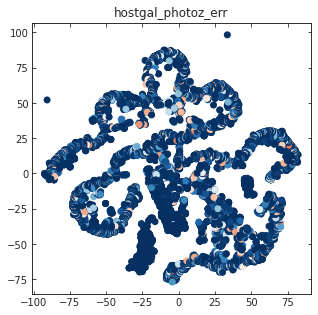

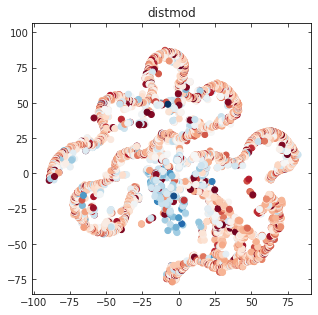

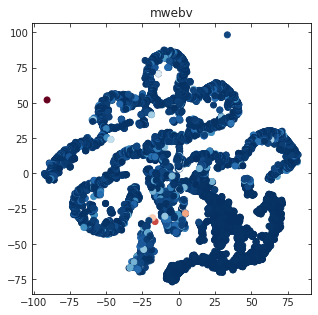

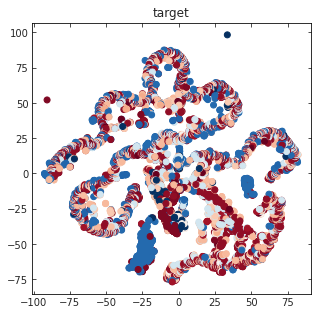

In [114]:
for col in metadata.columns:
    v = metadata[col].astype(float)
    pl.figure(figsize=(5,5))
    pl.title(col)
    pl.scatter(X_embedded[:,0], X_embedded[:,1],  color=[pl.cm.RdBu_r(Normalize(vmin=v.min(), vmax=v.max())(c))
                                                         for c in v])

    pl.show()